In [123]:
import os
import pickle
import time
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from collections import defaultdict
from numba import jit

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists
from power_planner.utils.utils_ksp import KspUtils

In [135]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitLG
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "ch_dump_s1_" + str(SCALE_PARAM) + ".dat")

with open("../config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        150, 250, cfg.RASTER, SCALE_PARAM
    )
    
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data
    
tic1 = time.time()
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
corridor = np.ones(instance_corr.shape) * 0.5  # start with all

graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=1)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight= 0.1 # cfg.ANGLE_WEIGHT
)
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
print("1) set cost rest")

graph type: <class 'power_planner.graphs.implicit_lg.ImplicitLG'>
defined pylon distances in raster: 3.0 5.0
cost weights [0.09090909 0.3030303  0.3030303  0.3030303 ]
instance shape (183, 624)
memory taken (dists shape): 3197376
1) set cost rest


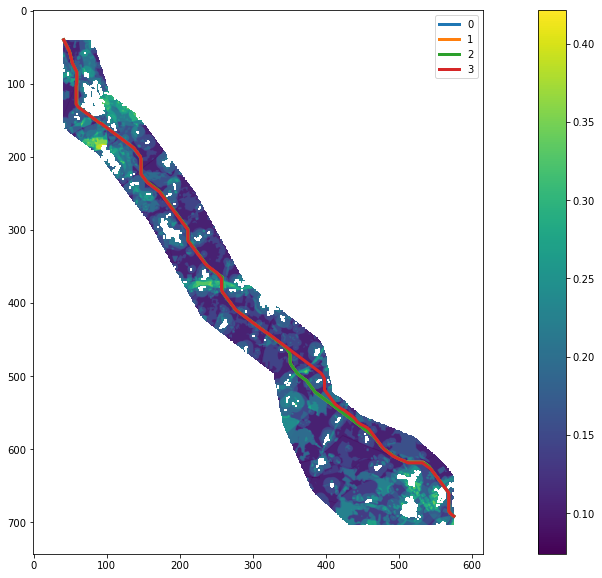

In [106]:
plt.figure(figsize=(20,10))
plt.imshow(graph.instance)
for i,path in enumerate(path_collection[-4:]):
    path = np.asarray(path)
    plt.plot(path[:,1], path[:,0], linewidth=3, label=i )# str(round(std_maxmin_max_2[i, 2],2)))
plt.legend()
plt.colorbar()
plt.show()

### Run one time to see best path

In [136]:
# compute first one
# modify dest inds because they are the highest one
graph.instance[tuple(dest_inds)] = graph.instance[tuple(start_inds)]
# compute path
graph.add_edges()
path, path_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
c = [graph.instance[i,j] for (i,j) in path]
print(np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum)
PREV_MAX = np.max(c)

# initialize the collections
path_collection = [path]
std_maxmin_max = [[np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum]]

time topo sort: 0.037
stack length 29365
time edges: 0.815
0.05197190660504627 0.2255618119254483 0.22632922632922634 8.37860044206235


### Run in loop to get the variants

In [137]:
while True:
    print("current max:", PREV_MAX)
    graph.add_nodes()
    # set the once above the previous maximum point to inf
    graph.instance[graph.instance>=PREV_MAX] = np.inf
    graph.instance[tuple(dest_inds)] = graph.instance[tuple(start_inds)]
    graph.add_edges()
    try:
        path, path_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
    except RuntimeWarning:
        print("already empty", PREV_MAX)
        break
    # collect result
    path_collection.append(path)
    c = [graph.instance[i,j] for (i,j) in path]
    print(np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum)
    std_maxmin_max.append([np.std(c), np.max(c)-np.min(c), np.max(c), cost_sum])
    PREV_MAX = np.max(c)

current max: 0.22632922632922634
memory taken (dists shape): 3197376
time topo sort: 0.038
stack length 28806
time edges: 1.38
0.052594482010906225 0.20666404302767943 0.20743145743145747 8.419493912127606
current max: 0.20743145743145747
memory taken (dists shape): 3197376
time topo sort: 0.03
stack length 28205
time edges: 0.745
0.05213730893669145 0.20200203836567474 0.20276945276945277 8.435423656392937
current max: 0.20276945276945277
memory taken (dists shape): 3197376
time topo sort: 0.026
stack length 28033
time edges: 1.226
0.051762273101826045 0.19179557815921452 0.19256299256299256 8.446116932637944
current max: 0.19256299256299256
memory taken (dists shape): 3197376
time topo sort: 0.046
stack length 27599
time edges: 1.583
0.05184390466809197 0.1889484253120617 0.18971583971583975 8.481709268279989
current max: 0.18971583971583975
memory taken (dists shape): 3197376
time topo sort: 0.041
stack length 27457
time edges: 0.693
0.052130208436019385 0.1846527210163574 0.1854201

In [129]:
# add means:
for p in range(len(std_maxmin_max)):
    path_len = len(path_collection[p])
    m = std_maxmin_max[p][3] / path_len
    std_maxmin_max[p].append(m)

In [130]:
np.asarray(std_maxmin_max)

array([[0.05197191, 0.22556181, 0.22632923, 8.37860044, 0.05336688],
       [0.05259448, 0.20666404, 0.20743146, 8.41949391, 0.05362735],
       [0.05213731, 0.20200204, 0.20276945, 8.43542366, 0.05372881],
       [0.05176227, 0.19179558, 0.19256299, 8.44611693, 0.05379692],
       [0.0518439 , 0.18894843, 0.18971584, 8.48170927, 0.05334408],
       [0.05213021, 0.18465272, 0.18542014, 8.55168679, 0.05378419],
       [0.05208819, 0.18335402, 0.18412143, 8.57750094, 0.05394655]])

Text(0.5, 1.0, 'Variance-cost tradeoff')

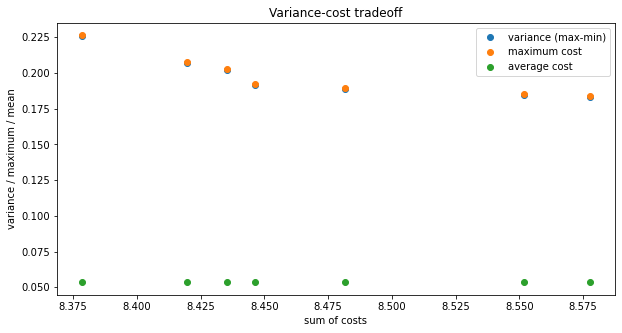

In [131]:
std_maxmin_max_2 = np.asarray(std_maxmin_max).copy()
plt.figure(figsize=(10,5))
# plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,0], label="standard deviation")
plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,1], label="variance (max-min)")
plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,2], label="maximum cost")
plt.scatter(std_maxmin_max_2[:,3], std_maxmin_max_2[:,4], label="average cost")
plt.legend()
plt.xlabel("sum of costs")
plt.ylabel("variance / maximum / mean")
plt.title("Variance-cost tradeoff")

### Vary edge weight

In [133]:
path_collection = []
labels = []
for e_w in [0.01, 0.1,0.3, 0.5, 0.7, 1]:
    graph.add_nodes()
    # set the once above the previous maximum point to inf
    graph.add_edges(edge_weight=e_w)
    try:
        path, path_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
    except RuntimeWarning:
        print("already empty", PREV_MAX)
        break
    # collect result
    path_collection.append(path)
    print(cost_sum)
    e_cost = (cost_sum - np.dot(graph.cost_weights, np.sum(np.array(path_costs), axis=0))) / e_w
    print(e_cost)
    c = [graph.instance[i,j] for (i,j) in path]
    print(np.sum(c))
    labels.append(f"edge weight: {e_w}, edge costs: {e_cost}, all costs: {cost_sum}")

memory taken (dists shape): 3197376
time topo sort: 0.041
stack length 22366
time edges: 2.087
already empty 0.18412143412143414


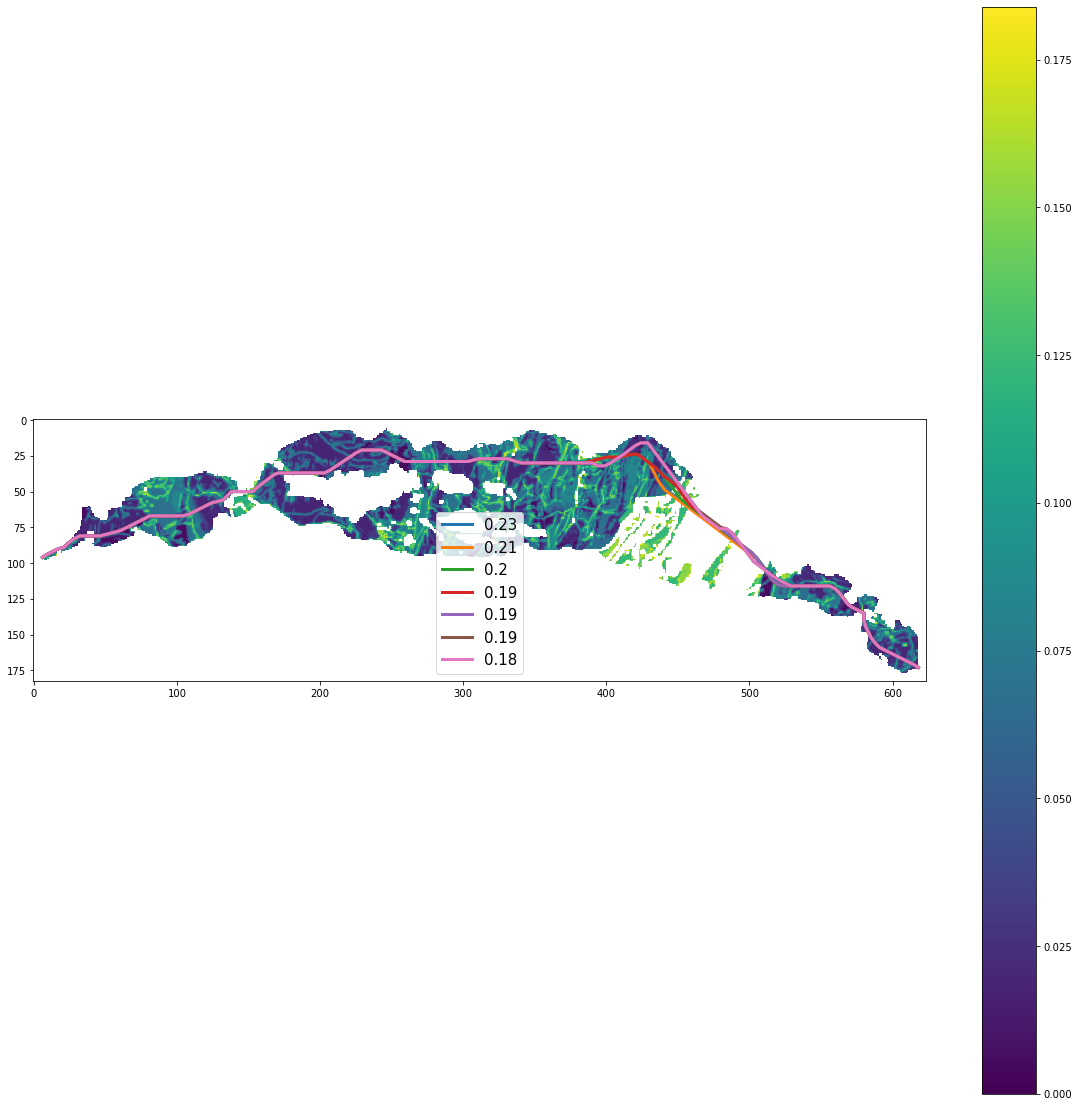

In [138]:
plt.figure(figsize=(20,20))
plt.imshow(graph.instance)
for i,path in enumerate(path_collection):
    path = np.asarray(path)
    plt.plot(path[:,1], path[:,0], linewidth=3, label=str(round(std_maxmin_max_2[i, 2],2))) # labels[i])# 
plt.legend(fontsize=15)
plt.colorbar()
plt.show()

## Implement angle selection algorithm

In [165]:
# test data
test_range = 200
for acd in [1, 5, 10, 15, 20, 30]:
    iterations = []
    for _ in range(100):
        test_c = (np.random.rand(test_range)*100).astype(int)
        c_tuples = [(c,i,0) for i,c in enumerate(test_c)]
        sorted_c = sorted(c_tuples, key = lambda x: x[0])

        # auxiliary lists
        e_update = [i for i in range(len(test_c))]
        to_update = np.ones(len(test_c))

        # queue
        q = []
        acd = 5
        update_counter = 1
        while np.any(to_update):
            # print(q)
            # print(sorted_c)
            # print(to_update)
            # print("------------")
            if len(q)>0 and q[0][0]< sorted_c[0][0]:
                cost, ind, div = q[0]
                del q[0]
            else:
                cost, ind, div = sorted_c[0]
                del sorted_c[0]
            # update step
            try:
                to_update[ind+div] = 0
                to_update[ind-div] = 0
            except IndexError:
                continue

            q.append((cost + acd, ind, div+1))
            update_counter+=1
        iterations.append(update_counter)
    print(np.mean(iterations), np.max(iterations)/test_range)

457.29 4.305
463.01 4.26
466.53 4.27
476.91 4.595
459.73 3.545
491.31 4.01


### What guarantees

much better than 100 times 100, but not simply times 2 or so

In [159]:
100 * np.log(100)

460.51701859880916